In [34]:
from NPRE449CP import *
solver = Solver('BWR')
solver.solveFluid(output=False)
solver.solvePinTemperature()

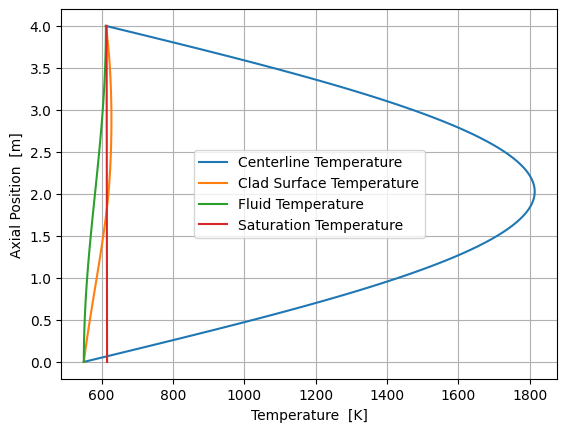

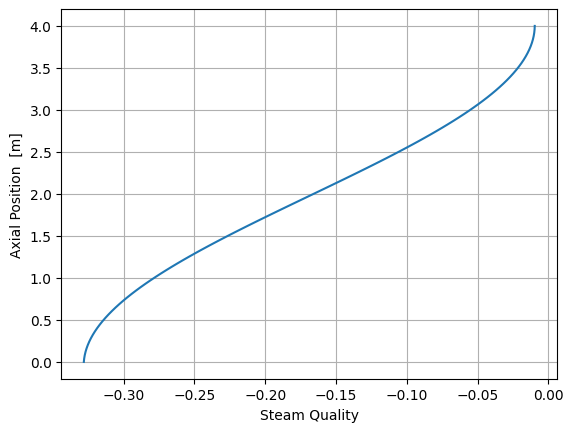

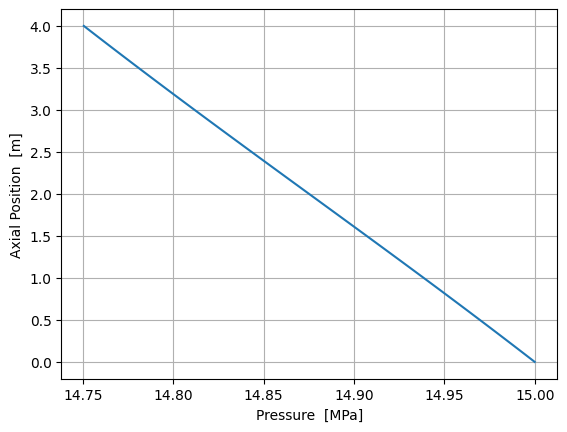

In [4]:
z = solver.z
Tcl = solver.TFuelFunc(0,z)
Tcs = solver.TCladS(z)
Tf = solver.TFluidFunc(z)
Tsat = [solver.fluid.tsat(p) for p in solver.PFunc(z)]
fig, ax = plt.subplots()
ax.plot(Tcl,z, label = 'Centerline Temperature')
ax.plot(Tcs,z,label = 'Clad Surface Temperature')
ax.plot(Tf, z, label = 'Fluid Temperature')
ax.plot(Tsat, z, label = 'Saturation Temperature')
ax.grid()
ax.legend()
ax.set_xlabel('Temperature  [K]')
ax.set_ylabel('Axial Position  [m]')
fig.savefig('tempplots.png',dpi=600)
plt.show()

fig,ax = plt.subplots()
ax.plot(solver.XeFunc(z),z)
ax.grid()
ax.set_ylabel('Axial Position  [m]')
ax.set_xlabel('Steam Quality')
fig.savefig('xeplot.png',dpi=600)
plt.show()

fig,ax = plt.subplots()
ax.plot(solver.PFunc(z),z)
ax.set_ylabel('Axial Position  [m]')
ax.set_xlabel('Pressure  [MPa]')
ax.grid()
fig.savefig('pressureplot.png',dpi=600)
plt.show()

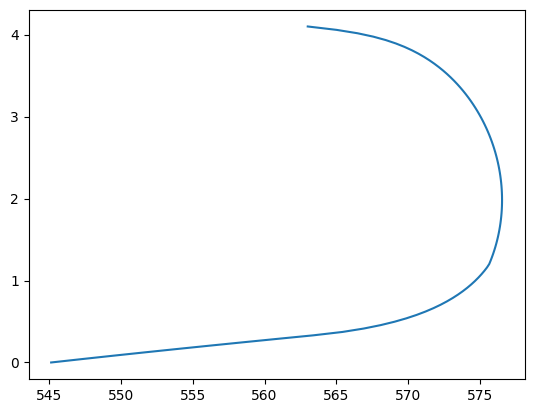

In [35]:
plt.plot(solver.TCladS(solver.z),solver.z)